In [30]:

# Generate graphs for demonstration purposes
import utils.graph_generators as gen
import torch
import dgl
import networkx as nx
from rdkit.Chem import Descriptors
from evaluation.moses.metrics.utils import *
from evaluation.moses.metrics import *
from evaluation.moses.dataset import *
from evaluation.evaluator import Evaluator
from evaluation.gin_evaluation import load_feature_extractor, MMDEvaluation
import copy
import fuckit

In [2]:
a=gen.load_zinc(n_samples=10)
grids=a
lobsters=a
#print(len(grids[0].ndata['attr']))
#print(grids[0].ndata['attr']  , grids[0].ndata['feat'])

In [3]:


lobsters = [ dgl.to_networkx(g, node_attrs=['attr','feat'], edge_attrs=['attr','feat'])  for g in a]
grids = [dgl.to_networkx(g, node_attrs=['attr','feat'], edge_attrs=['attr','feat']) for g in a]

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

device=torch.device('cpu')

grids = [ dgl.from_networkx(g,node_attrs=['feat'], edge_attrs=['feat']).to(device) for g in grids] # Convert graphs to DGL from NetworkX
lobsters = [ dgl.from_networkx(g,node_attrs=['feat'], edge_attrs=['feat']).to(device) for g in lobsters] # Convert graphs to DGL from NetworkX

In [5]:

# Compute all GNN-based metrics at once
evaluator = Evaluator(device=device)
all_gnn=evaluator.evaluate_all(generated_dataset=grids, reference_dataset=lobsters)
print(all_gnn)
 #Alternatively, compute a single GNN-based metric. See evaluation/gin_evaluation.py for other metrics.
# Can tweak GIN hyperparameters, however defaults are set to our recommendations
gin = load_feature_extractor(device=device)
# Can tweak hyperparameters of MMD RBF, however defaults are set to our recommendations
mmd_eval = MMDEvaluation(gin)
result, time = mmd_eval.evaluate(generated_dataset=grids, reference_dataset=lobsters)
print('The single gin  metric recommended by the https://github.com/uoguelph-mlrg/GGM-metrics/search?q=prdcEvaluation: {}, time to compute: {:.3f}s'.format(result, time))

# Evaluation incorporating custom node/edge features.
# If no node features are provided, the default is degree features
# expressed as an integer.

node_feat_loc = 'feat'
edge_feat_loc = 'feat'
node_feat_dim = 10
edge_feat_dim = 5

# Create random node/edge features
for g in grids:
    num_nodes = g.number_of_nodes()
    g.ndata[node_feat_loc] = torch.randn(num_nodes, node_feat_dim).to(g.device)
    num_edges = g.number_of_edges()
    g.edata[edge_feat_loc] = torch.randn(num_edges, edge_feat_dim).to(g.device)
    
for g in lobsters:
    num_nodes = g.number_of_nodes()
    g.ndata[node_feat_loc] = torch.randn(num_nodes, node_feat_dim).to(g.device)
    num_edges = g.number_of_edges()
    g.edata[edge_feat_loc] = torch.randn(num_edges, edge_feat_dim).to(g.device)

# Load GIN
gin = load_feature_extractor(
    device=device, input_dim=node_feat_dim, edge_feat_dim=edge_feat_dim,
    node_feat_loc=node_feat_loc, edge_feat_loc=edge_feat_loc)

mmd_eval = MMDEvaluation(gin)
result, time = mmd_eval.evaluate(generated_dataset=lobsters, reference_dataset=grids)
print('result: {}, time to compute: {:.3f}s'.format(result, time))

# To quickly demonstrate sensitivity to node/edge features, let's create
# a copy of the grid graphs and slightly alter the node/edge feat distributions

result, time = mmd_eval.evaluate(generated_dataset=grids, reference_dataset=grids)
print('MMD RBF for grids with itself: {}'.format(result['mmd_rbf']))

grids_copy = [copy.deepcopy(g) for g in grids]
for g in grids_copy:
    g.ndata[node_feat_loc] *= 1.15
    g.edata[edge_feat_loc] *= 1.15
    
result, time = mmd_eval.evaluate(reference_dataset=grids, generated_dataset=grids_copy)
print('MMD RBF after altering node/edge feat. distributions: {}'.format(result['mmd_rbf']))

orthogonal


ValueError: not enough values to unpack (expected 3, got 2)

In [39]:
evaluator = Evaluator(device=device, metrics_type=['gin','structure', 'molecular'],feature_extractor='mmd-structure',statistic='all' )
evaluator.evaluate_all(generated_dataset=grids, reference_dataset=lobsters)

c:\Users\cs843\Documents\PhD\2023\February\GGM-metrics\evaluation\graph_structure_evaluation.py:128: RuntimeWarning: Mean of empty slice.
  mmd = K_GG.mean() + K_RR.mean() - (2 * K_GR.mean())
c:\Users\cs843\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


{'nspdk_mmd': 0.0,
 'nspdk_mmd_time': 0.2050020694732666,
 'wl_mmd': 0.0,
 'wl_mmd_time': 0.021051883697509766,
 'degree_mmd': 0,
 'degree_mmd_time': 51.9702832698822,
 'clustering_mmd': 0,
 'clustering_mmd_time': 54.76243257522583,
 'orbits_mmd': 0,
 'orbits_mmd_time': 0.07057380676269531,
 'spectral_mmd': 0,
 'spectral_mmd_time': 33.53386616706848}

In [40]:
# To quickly demonstrate sensitivity to node/edge features, let's create
# a copy of the grid graphs and slightly alter the node/edge feat distributions

result, time = mmd_eval.evaluate(generated_dataset=grids, reference_dataset=grids)
print('MMD RBF for grids with itself: {}'.format(result['mmd_rbf']))

grids_copy = [copy.deepcopy(g) for g in grids]
for g in grids_copy:
    g.ndata[node_feat_loc] *= 5
    g.edata[edge_feat_loc] *= 5
    
result, time = mmd_eval.evaluate(reference_dataset=grids, generated_dataset=grids_copy)
print('MMD RBF after altering node/edge feat. distributions: {}'.format(result['mmd_rbf']))

MMD RBF for grids with itself: 0
MMD RBF after altering node/edge feat. distributions: 1.0694464147090912


In [ ]:
#What sort of preprocessing  you need to make to be able to execute the metrics from moses

#https://github.com/graphdeeplearning/benchmarking-gnns/issues/42
#https://stackoverflow.com/questions/51195392/smiles-from-graph


In [43]:
lobsters = [ dgl.to_networkx(g, node_attrs=['attr','feat'], edge_attrs=['attr','feat'])  for g in a]
grids = [dgl.to_networkx(g, node_attrs=['attr','feat'], edge_attrs=['attr','feat']) for g in a]

In [12]:

def get_atomic_number():
    dict_of_atomic_no ={ 'C':6, 'O':8, 'N':7, 'F':9, 'S':16, 'Cl':17,  'Br':35, 'I':53, 'P':15}
    return dict_of_atomic_no

def get_dict_of_nodes():
    dict_of_nodes={0: 'C', 1: 'O',2: 'N',3: 'F',4: 'C',5: 'S', 6: 'Cl', 7: 'O', 8: 'N',9: 'Br', 10: 'N', 11: 'N', 12: 'N', 13: 'N', 14: 'S ', 15: 'I', 16: 'P', 17: 'O', 18: 'N', 19: 'O',20: 'S', 21: 'P' ,22: 'P',23: 'C', 24: 'P',25: 'S',26: 'C',27: 'P'}
    return dict_of_nodes

def nx_to_mol(nx_graph , edge_label='feat', node_label='feat'):
    # create empty editable mol object
    mol = Chem.RWMol()

    # add atoms to mol and keep track of index
    node_to_idx = {}
    
    #dictionary of atomic numbers
    dict_of_atomic_no=get_atomic_number()
    
    #dictionary of nodes
    node_atom_values=get_dict_of_nodes()
    
    
    for i,n in enumerate(nx_graph.nodes(data=True)):
        a = Chem.Atom( dict_of_atomic_no[node_atom_values[int(n[1][node_label].numpy())]])
        molIdx = mol.AddAtom(a)
        #print(molIdx)
        node_to_idx[i] = molIdx
        
    for edge in nx_graph.edges(data=True):
            bond=int(edge[2][edge_label])
            ix=edge[0]
            iy=edge[1]
            
            # only traverse half the matrix
            if iy <= ix:
                continue
            if bond == 1:
                bond_type = Chem.rdchem.BondType.SINGLE
                mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
            elif bond == 2:
                bond_type = Chem.rdchem.BondType.DOUBLE
                mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
                
            elif bond == 3:
                    bond_type=Chem.rdchem.BondType.TRIPLE
                    mol.AddBond(node_to_idx[ix], node_to_idx[iy] ,bond_type)
            elif bond == 4:
                bond_type = Chem.rdchem.BondType.AROMATIC
                mol.AddBond(node_to_idx[ix], node_to_idx[iy] ,bond_type)

        # Convert RWMol to Mol object
    mol = mol.GetMol()  
    try:
        Chem.SanitizeMol(mol)
    except:
        # print(node_list)
        # print(Chem.MolToSmiles(mol))
        return None
    return mol       



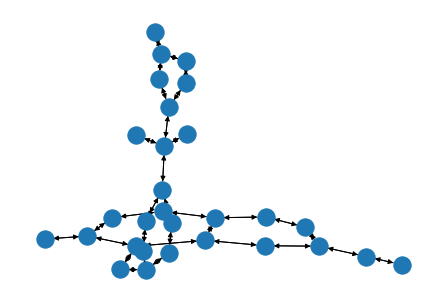

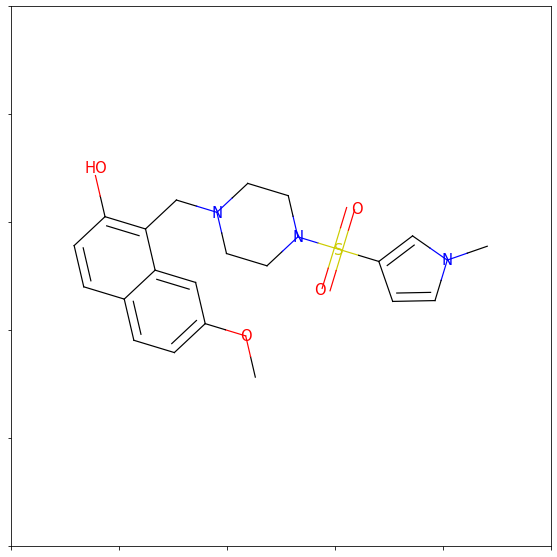

In [235]:
for g in lobsters:
   nx.draw(g)
   Draw.MolToMPL(nx_to_mol(g))
   break
   

In [45]:
losters_mol= [nx_to_mol(g) for g in lobsters]
grids_mol=[nx_to_mol(g) for g in grids]

In [46]:

lobsters_smiles=[Chem.MolToSmiles(g) for g in losters_mol]
grids_smiles=[Chem.MolToSmiles(g) for g in grids_mol]


In [239]:
get_all_metrics(gen=lobsters_smiles,test=lobsters_smiles)

c:\Users\cs843\Documents\PhD\2023\February\GGM-metrics\evaluation\moses\metrics\metrics.py:216: UserWarning: Can't compute unique@1000.gen contains only 10 molecules
  warnings.warn(
c:\Users\cs843\Documents\PhD\2023\February\GGM-metrics\evaluation\moses\metrics\metrics.py:216: UserWarning: Can't compute unique@10000.gen contains only 10 molecules
  warnings.warn(


[<rdkit.Chem.rdchem.Mol object at 0x00000131359DCDC0>, <rdkit.Chem.rdchem.Mol object at 0x000001314AF4FCA0>, <rdkit.Chem.rdchem.Mol object at 0x000001314AF4F880>, <rdkit.Chem.rdchem.Mol object at 0x000001314AF4FC40>, <rdkit.Chem.rdchem.Mol object at 0x000001314AF4FA60>, <rdkit.Chem.rdchem.Mol object at 0x000001314AF4F8E0>, <rdkit.Chem.rdchem.Mol object at 0x000001314AF4FA00>, <rdkit.Chem.rdchem.Mol object at 0x000001314AF4FAC0>, <rdkit.Chem.rdchem.Mol object at 0x000001314AF4FBE0>, <rdkit.Chem.rdchem.Mol object at 0x000001314AF4F940>]


{'valid': 1.0,
 'unique@1000': 1.0,
 'unique@10000': 1.0,
 'FCD/Test': -1.0525771344305213e-05,
 'SNN/Test': 1.0,
 'Frag/Test': 1,
 'Scaf/Test': 1,
 'FCD/TestSF': 47.06954094903616,
 'SNN/TestSF': 0.4751725435256958,
 'Frag/TestSF': -0.03829807449991973,
 'Scaf/TestSF': 0.0,
 'IntDiv': 0.7798648965358734,
 'IntDiv2': 0.6573560342604137,
 'Filters': 0.6,
 'logP': 0.0,
 'SA': 0.0,
 'QED': 0.0,
 'weight': 0.0,
 'Novelty': 0.9}

In [7]:
grids

[Graph(num_nodes=29, num_edges=64,
       ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}),
 Graph(num_nodes=26, num_edges=56,
       ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}),
 Graph(num_nodes=16, num_edges=34,
       ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}),
 Graph(num_nodes=27, num_edges=60,
       ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}),
 Graph(num_nodes=21, num_edges=44,
       ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}),
 Graph(num_nodes=28, num_edges=60,
       ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=

In [9]:
lobsters = [ dgl.to_networkx(g, node_attrs=['attr','feat'], edge_attrs=['attr','feat'])  for g in a]
grids = [dgl.to_networkx(g, node_attrs=['attr','feat'], edge_attrs=['attr','feat']) for g in a]
grids = [ dgl.from_networkx(g,node_attrs=['feat'], edge_attrs=['feat']).to(device) for g in grids] # Convert graphs to DGL from NetworkX
lobsters = [ dgl.from_networkx(g,node_attrs=['feat'], edge_attrs=['feat']).to(device) for g in lobsters] # Convert graphs to DGL from NetworkX

In [31]:
device=torch.device('cpu')
metrics_type=['nn', 'structural', 'molecular']
structural_statistic='nspdk'  #options ['WL' , 'nspdk', 'orbits, 
#'degree', 'clustering' ,'spectral']


reference_graphs=[]
generated_graphs=[]
discrete_node_label_name='' #leave blank if this does not exist
continous_node_label_name=''  #leave blank if this does not exist
discrete_edge_label_name=''  #leave blank if this does not exist
continous_edge_label_nane='' #leave blank if this does not exist
#dicrete labels should be set to 'label'
#continous labels should be set to 'attr'


metrics={}
if  'nn' in metrics_type:
    eval=Evaluator(feature_extractor ='gin',device='cpu')
    metrics.update(eval.evaluate_all(generated_dataset=grids,reference_dataset=lobsters))
if 'structural' in metrics_type  :
    eval=Evaluator(feature_extractor ='mmd-structure',device='cpu' ,statistic=structural_statistic)
    metrics.update(eval.evaluate_all(generated_dataset=grids,reference_dataset=lobsters))
if 'molecular'  in metrics_type:
    
    @fuckit
    def func():
        losters_mol= [nx_to_mol(g) for g in lobsters]
        grids_mol=[nx_to_mol(g) for g in grids]
        lobsters_smiles=[Chem.MolToSmiles(g) for g in losters_mol]
        grids_smiles=[Chem.MolToSmiles(g) for g in grids_mol]
        metrics.update(get_all_metrics(gen=lobsters_smiles,test=lobsters_smiles))
    try: func
    except:
           print('Cannot compute molecular metrics for this type of graphs')
        
    
print(metrics)

orthogonal
{'activations_time': 0.018514633178710938, 'fid': -3.6513307861696376e-06, 'fid_time': 0.02151346206665039, 'kid': -0.51306605, 'kid_time': 0.039520978927612305, 'precision': 1.0, 'recall': 1.0, 'f1_pr': 1.00001, 'precision_time': 0.06002449989318848, 'recall_time': 0.06002449989318848, 'f1_pr_time': 0.06002449989318848, 'density': 1.2000000000000002, 'coverage': 1.0, 'f1_dc': 1.090919173552968, 'density_time': 0.04603171348571777, 'coverage_time': 0.04603171348571777, 'f1_dc_time': 0.04603171348571777, 'mmd_rbf': 0, 'mmd_rbf_time': 0.06151318550109863, 'mmd_linear': 0.0, 'mmd_linear_time': 0.018514633178710938, 'nspdk_mmd': 0.0, 'nspdk_mmd_time': 0.3265414237976074}


In [272]:
eval=Evaluator(feature_extractor ='mmd-structure',statistic='WL')
eval.evaluate_all(generated_dataset=grids,reference_dataset=lobsters)

{'wl_mmd': 0.0, 'wl_mmd_time': 0.019949913024902344}

In [273]:
eval=Evaluator(feature_extractor ='mmd-structure',statistic='nspdk')
eval.evaluate_all(generated_dataset=grids,reference_dataset=lobsters)

{'nspdk_mmd': 0.0, 'nspdk_mmd_time': 0.164459228515625}

In [274]:
eval=Evaluator(feature_extractor ='mmd-structure',statistic='clustering')
eval.evaluate_all(generated_dataset=grids,reference_dataset=lobsters)

{'clustering_mmd': 0, 'clustering_mmd_time': 68.12237238883972}

In [275]:
eval=Evaluator(feature_extractor ='mmd-structure',statistic='degree')
eval.evaluate_all(generated_dataset=grids,reference_dataset=lobsters)

{'degree_mmd': 0, 'degree_mmd_time': 62.189956188201904}

In [4]:
eval=Evaluator(feature_extractor ='mmd-structure',statistic='clustering')
eval.evaluate_all(generated_dataset=grids,reference_dataset=lobsters)

{'clustering_mmd': 0, 'clustering_mmd_time': 55.546926975250244}

In [5]:

#beware the graph statistics metric it is very slow
eval=Evaluator(feature_extractor ='mmd-structure',statistic='all')
metrics=eval.evaluate_all(generated_dataset=grids[:5],reference_dataset=lobsters[5:])